In [10]:
%matplotlib inline
import numpy as np
from PIL import Image
import cv2
import csv
from tqdm.notebook import tqdm
import os
import pandas as pd
from matplotlib import pyplot as plt
from tracktor.utils import class_index

from tracktor.utils import classes, class_index, rand_cmap

In [2]:
folder = "../../data/strandvejen_faxe"
file_names = sorted(os.listdir(folder), key = lambda x: x[:4])
file_path = [folder + "/" + name for name in file_names]

In [3]:
model_output = pd.read_csv(
    "../../output/custom/results/strandvejen_faxe.csv",
    header=None)
model_output.columns = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "confidence", "x", "y", "z", "label_index"]
model_output['label'] = (model_output['label_index']).map(lambda x: classes[class_index[str(x)]])

In [4]:
labels = model_output['label'].unique().tolist()
colors = rand_cmap(nlabels=len(labels),
                   type='bright',
                   first_color_black=False)


def get_color(label):
    return tuple(map(lambda x: x*255, colors(labels.index(label))))
    

def get_img(img_path):
    img = cv2.imread(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = cv2.resize(img, (512, 512))
    return img

def hist_eq(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]

def print_img(img):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap='Greys_r')
    
def draw_bounding(img, x1, x2, y1, y2, label, color):
    # draw a rectangle on the image
    h, w = img.shape[:2]
    cv2.putText(img, label , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

In [5]:
model_output.head(3)

,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z,label_index,label
0,1,1,415.529205,883.629517,272.624481,44.463928,0.976817,-1,-1,-1,16,area patch
1,1,2,410.430847,884.256531,431.503845,135.769409,0.680714,-1,-1,-1,16,area patch
2,1,3,940.656555,911.622864,68.743896,40.659363,0.534440,-1,-1,-1,10,crack


In [6]:
i = 10
one_frame = get_img(file_path[i])
frame_boxes_df = model_output[model_output["frame"] == i]
frame_boxes_df

,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z,label_index,label
23,10,24,570.249512,684.990234,437.657654,336.406677,0.432196,-1,-1,-1,16,area patch


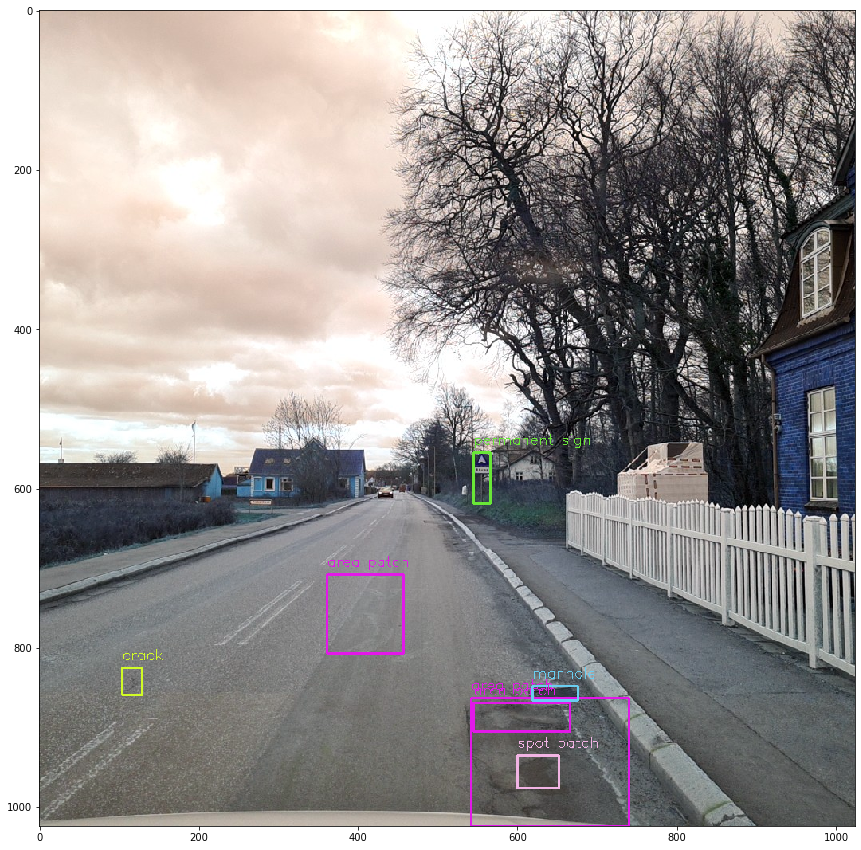

In [12]:
for i in tqdm(range(len(model_output['frame'].unique()))):
    one_frame = get_img(file_path[i])
    frame_boxes_df = model_output[model_output["frame"] == i+1]
    if (len(frame_boxes_df.label.unique()) < 5): continue
    output_img = one_frame.copy()
    for i, row in frame_boxes_df.iterrows():
        x1 = float(row.bb_left) - 1
        y1 = float(row.bb_top) - 1
        x2 = float(row.bb_width) - 1 + x1
        y2 = float(row.bb_height) - 1 + y1
        draw_bounding(output_img, int(x1), int(x2), int(y1), int(y2), row.label, get_color(row.label))
    break
print_img(output_img)

In [8]:
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter("tracktor_video.avi", fourcc, 30, (1024, 1024), True)
for i in tqdm(range(len(model_output['frame'].unique()))):
    one_frame = get_img(file_path[i])
    frame_boxes_df = model_output[model_output["frame"] == i+1]
    output_img = one_frame.copy()
    for _, row in frame_boxes_df.iterrows():
        x1 = float(row.bb_left) - 1
        y1 = float(row.bb_top) - 1
        x2 = float(row.bb_width) - 1 + x1
        y2 = float(row.bb_height) - 1 + y1
        draw_bounding(
            output_img,
            int(x1), int(x2), int(y1), int(y2),
            f"[{row.id}] {row.label} - {round(row.confidence*100)}%]",
            color=get_color(row.label)
        )
    writer.write(output_img)
writer.release()


In [9]:
frame_boxes_df

,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z,label_index,label
8906,1520,6605,525.359009,724.551697,101.491089,293.754517,0.160131,-1,-1,-1,16,area patch
9119,1520,6759,1.000000,905.166260,132.632339,55.477295,0.305338,-1,-1,-1,16,area patch
9138,1520,6777,836.212463,720.011536,189.787537,270.258423,0.929034,-1,-1,-1,16,area patch
9139,1520,6778,920.238647,722.054688,104.841431,93.550903,0.842800,-1,-1,-1,16,area patch
9140,1520,6779,564.853027,709.062195,20.106262,30.780884,0.583232,-1,-1,-1,16,area patch
9141,1520,6780,30.368652,902.070374,604.665161,113.804810,0.577379,-1,-1,-1,10,crack
